# Behavior of the Adaline convergence
Below we import the entire Adaline code from the previous example:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

plt.rcParams["figure.figsize"] = [10, 8]
matplotlib.rc("savefig", dpi=200)

from IPython.display import display, Javascript

disable_js = """
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""
display(Javascript(disable_js))

<IPython.core.display.Javascript object>

In [3]:
np.random.seed(7) # chosen to include a "bad point"

In [4]:
# module for file access
import os.path

# global file name of our data source
file_name = 'iris.csv'

def fetch_iris_data():
    '''
    Fetch data from an internet archive and save as file `iris.csv`.
    '''

    df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
                     header=None)
    df.to_csv(file_name, header=None, index=False)

    return

# fetch data from internet source only if the file is not available locally
if not os.path.exists(file_name):
    fetch_iris_data()

In [5]:
df = pd.read_csv(file_name, header=None)

In [6]:
def prep_iris_data(df):
    ''' 
    Fetches 2d data points from the iris data from the pandas dataframe `df` and
    return (X, Y), where X is a list of 2d points and Y a list of labels.
    '''
    
    # as feature we take the first two data entries,
    # which are sepal length and width
    X = df.iloc[:, 0:2].values

    # read class labels and convert them to numers as follow:
    # `iris-setosa` set to value -1, `iris-versicol` as well as `iris-virginica` to value 1
    Y = df.iloc[:, 4].values 
    Y = np.where(Y == 'Iris-setosa', -1, 1)
    
    # to make it more realistic, we randomize the data
    indices = np.random.permutation(len(X))
    X_rand = [X[i] for i in indices]
    Y_rand = [Y[i] for i in indices]

    # return the randomized lists as numpy arrays
    return np.array(X_rand), np.array(Y_rand)

In [7]:
def plot_data(X, Y):
    '''
    Plot the data X, setosa in red, and others in blue.
    '''

    # divide data depedning on the label: iris-setosa or other
    X_setosa = []
    X_other = []
    for x, y in zip(X, Y):
        if y == -1:
            X_setosa.append(x)
        else:
            X_other.append(x)
   
    # convert to numpy array
    X_setosa = np.array(X_setosa)
    X_other = np.array(X_other)

    # plot the two lists with different styles
    plt.scatter(X_setosa[:, 0], X_setosa[:, 1], color='red', marker='o', label='setosa')
    plt.scatter(X_other[:, 0], X_other[:, 1], color='blue', marker='o', label='other')

    # decorate plot
    plt.xlabel('sepal length')
    plt.ylabel('sepal width')
    plt.legend(loc='upper right')

    # show plot which does not return until the window is closed
    plt.show(block=False)

    return

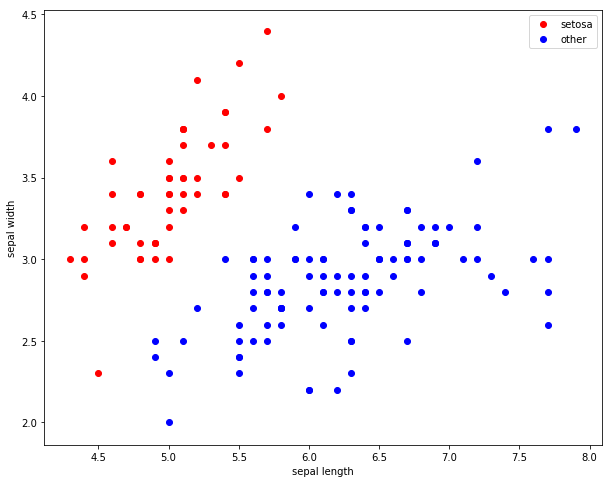

In [8]:
# if you do not have the csv data file call fetch_iris_data() by removing the comment in the line below
# fetch_iris_data()

X_all, Y_all = prep_iris_data(df)

plot_data(X_all, Y_all)

In [9]:
class LossSVM:

    def __init__(self, X_train, Y_train, mu=1.0):
        """
        Initialize the parameter `mu` which specifies the weighting
        between margin width and the distance to the support vectors, and
        furthermore, the training data `X_train` and `Y_train`.
        """
    
        self.mu_ = mu

        self.xi_ = X_train
        self.yi_ = Y_train

        return

    def val(self, w):
        """
        Computes a value of the loss function for a given weight vector.
        """

        self.margin = 1 - self.yi_ * ( np.dot(self.xi_, w[1:]) + w[0] )

        w_norm = 1/2 * np.sum( w[1:]**2 )
        margin_violations = np.where(self.margin >= 0, self.margin, 0)
        margin_avg = margin_violations.sum() / len(self.xi_)

        return w_norm + self.mu_ * margin_avg, w_norm, margin_avg

    def diff(self, w):
        """
        Computes the derivative of the loss function for a given weight vector.
        """

        self.margin = 1 - self.yi_ * ( np.dot(self.xi_, w[1:]) + w[0] )

        w0_sub_diff1 = - self.yi_
        w0_sub_diffs = np.where(self.margin >= 0, w0_sub_diff1, 0)
        w0_diffs_avg = w0_sub_diffs.sum() / len(self.xi_)

        w_sub_diff1 = - self.xi_ * self.yi_[:,np.newaxis]
        w_sub_diffs = np.where(self.margin[:,np.newaxis] >= 0, w_sub_diff1, 0)
        w_diffs_avg = w_sub_diffs.sum(axis=0) / len(self.xi_)

        ret0 = np.array([ w0_diffs_avg ])
        ret_vec = w[1:] + self.mu_ * w_diffs_avg

        return np.append(ret0, ret_vec)

In [10]:
class SVM():

    def __init__(self, num):
        '''
        initialize class for `num` input signals
        '''

        # weights of the Adaline, initialized to zero
        # note the '1 + ' as the first weight entry is the threshold
        self.w_ = np.zeros(1 + num)

        return
    
    def activation_input(self, X):
        '''
        calculate the activation input of the neuron
        '''
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def classify(self, X):
        '''
        classify the data by sending the activation input through a step function
        '''
        return np.where(self.activation_input(X) >= 0.0, 1, -1)
    
    def learn(self, X_train, Y_train, mu=1.0, eta=0.001, epochs=1000):
        '''
        fit training data according to eta and n_iter
        and log the errors in errors_
        '''

        # we initialize two list, each for the misclassifications and the cost function
        self.train_errors_ = []
        self.train_loss_ = []
        self.train_wnorm_ = []
        self.train_violation_ = []

        # for all the epoch
        for _ in range(epochs):
            # classify the traning features
            Z = self.classify(X_train)
            # count the misqualifications for the logging
            err = 0
            for z, y in zip(Z, Y_train):
                err += int(z != y)
            # ans save them in the list for later use
            self.train_errors_.append(err)

            loss = LossSVM(X_train, Y_train, mu=mu)
            # compute loss for this epoch
            loss_val, wnorm_val, violation_val = loss.val(self.w_)
            self.train_loss_.append( loss_val )  
            self.train_wnorm_.append( wnorm_val )  
            self.train_violation_.append( violation_val )  
            # compute gradient of loss function and with it the update for w
            delta_w = - eta * loss.diff(self.w_)
            # update the weights
            self.w_ += delta_w

        return     
    
    def plot_train_loss(self):
        '''
        plots the loss function value per epoch
        '''

        # create two lists, one enumerating the epochs, the other the cost values
        epochs, vals = np.arange(len(self.train_loss_)), np.array(self.train_loss_)

        # plot the loss per epoch
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('loss')
        axs.set_title('Loss during training')
        plt.plot(epochs, vals)

        return
    
    def plot_train_wnorm(self):
        '''
        plots the norm of w summand of the loss function value per epoch
        '''

        # create two lists, one enumerating the epochs, the other the cost values
        epochs, vals = np.arange(len(self.train_wnorm_)), np.array(self.train_wnorm_)

        # plot the loss per epoch
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('L2 norm of w')
        axs.set_title('Half L2 norm of w width  during training')
        plt.plot(epochs, vals)

        return

    def plot_train_violation(self):
        '''
        plots the margin violation summand of the loss function value per epoch
        '''

        # create two lists, one enumerating the epochs, the other the cost values
        epochs, vals = np.arange(len(self.train_violation_)), np.array(self.train_violation_)

        # plot the loss per epoch
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('margin violation')
        axs.set_title('Average margin violation during training')
        plt.plot(epochs, vals)

        return

    
    def plot_decision_regions(self, X, Y, X_train, Y_train, resolution):

        # set up a 2d mesh of data points with resolution `resolution`
        x1_min, x1_max = X[:, 0].min() - 2, X[:, 0].max() + 2
        x2_min, x2_max = X[:, 1].min() - 2, X[:, 1].max() + 2

        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))

        # start new plot
        fig = plt.figure()
        axs = plt.gca()

        # make fictitious feature data out of the above 2d mesh
        x_mesh = np.array( [xx1.ravel(), xx2.ravel()] ).T
        # let the Adaline classify these features
        Z = self.classify(x_mesh)
        Z = Z.reshape(xx1.shape)

        # plot the mesh as contour plot
        axs.contourf(xx1, xx2, Z, alpha=0.4, cmap=matplotlib.colors.ListedColormap(['red', 'blue']))
        axs.set_xlim(xx1.min(), xx1.max())
        axs.set_ylim(xx2.min(), xx2.max())
        
        # sort the input data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X, Y):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)

        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='.', label='Setosa')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='.', label='Other')
        
        # sort the training data according to the flower species
        X_setosa = []
        X_other = []
        for x, y in zip(X_train, Y_train):
            if y == -1:
                X_setosa.append(x)
            else:
                X_other.append(x)

        # turn the array into numpy arrays
        X_setosa = np.array(X_setosa)
        X_other = np.array(X_other)
        
        # and make a scatter plot with different styles for the two different species
        axs.scatter(X_setosa[:, 0], X_setosa[:, 1], 
                    color='red', marker='x', label='S. training')
        axs.scatter(X_other[:, 0], X_other[:, 1], 
                    color='blue', marker='x', label='O. training')

        # add some additional annotations of the plot
        axs.set_xlabel('sepal length')
        axs.set_ylabel('sepal width')
        axs.legend(loc='upper right')
        axs.set_title('SVM')

        return

    def plot_train_errors(self):
        '''
        plot the number of misclassifications per epoch
        '''

        # create two list, one with epoch numbers, and one with the errors per epoch
        epochs, num_errs = np.arange(len(self.train_errors_)), np.array(self.train_errors_)

        # plot the above data
        fig = plt.figure()
        axs = plt.gca()
        axs.set_xlabel('epoch')
        axs.set_ylabel('errors')
        axs.set_title('Errors during training')
        plt.plot(epochs, num_errs)

        return

    def efficiency(self, X_test, Y_test): 
        '''
        compute the efficiency = 1 - number of misclassifications / number of data points
        '''

        err = 0
        
        # classify the test data
        Z = self.classify(X_test)
        for z, y in zip(Z, Y_test):
            err += int(z != y)

        return 1 - float(err) / len(X_test)

In [11]:
train_samples = int( len(X_all) / 3 )

# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]

# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

svm = SVM(X.shape[1])

## Dependence on $\mu$
Our objective is to visualize the learning process and get an idea about the dependence on training data as well as the learning rate.

First we look at two training phases with learning rates that are two orders of magnitude apart.

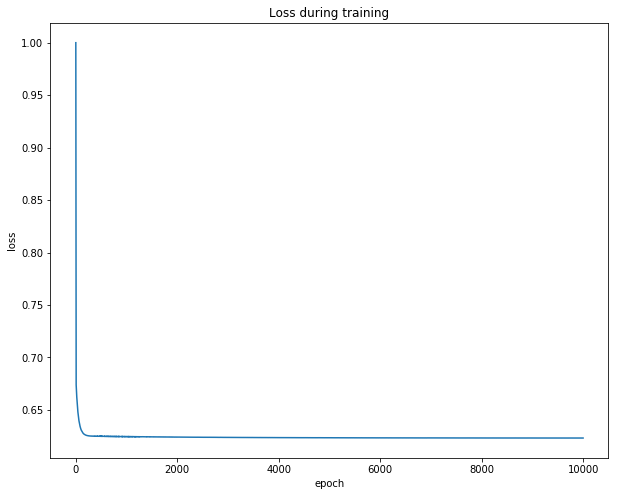

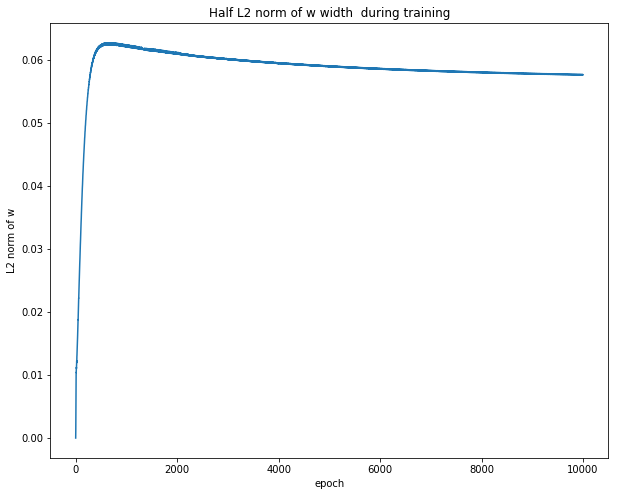

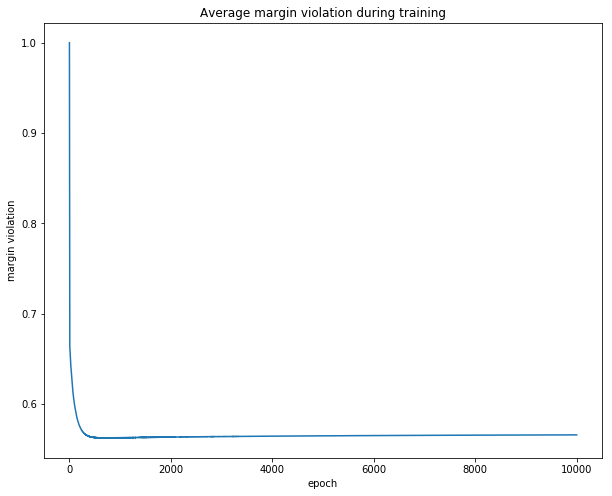

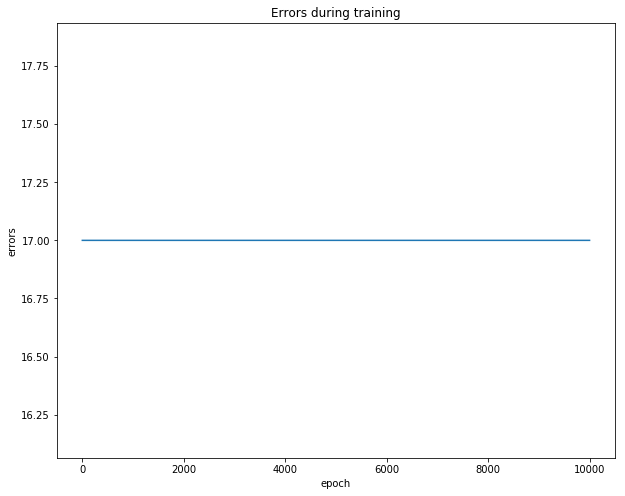

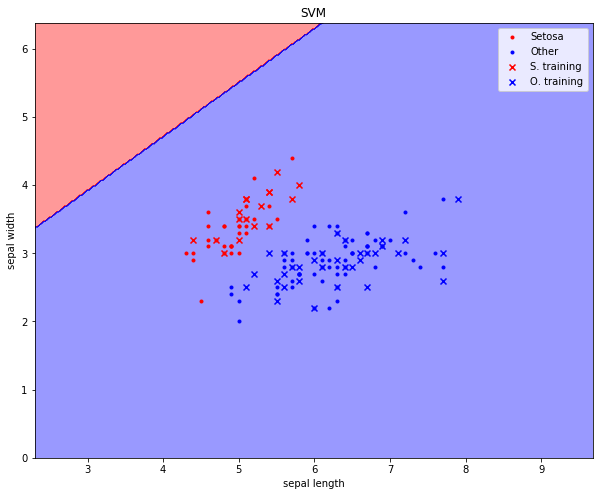

Efficiency (train) = 0.6599999999999999
Efficiency (test)  = 0.6699999999999999
Efficiency (all)   = 0.6666666666666667


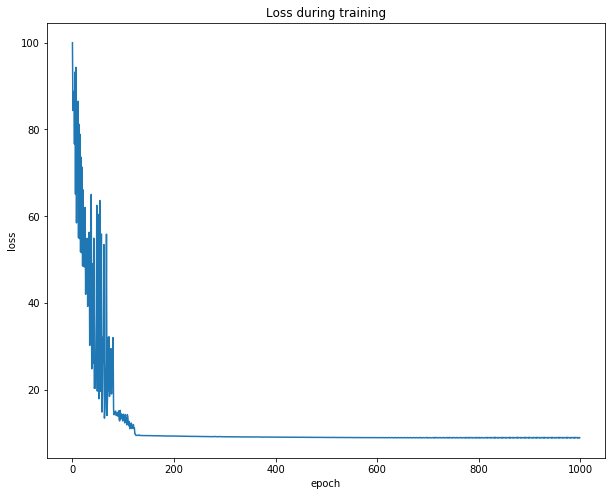

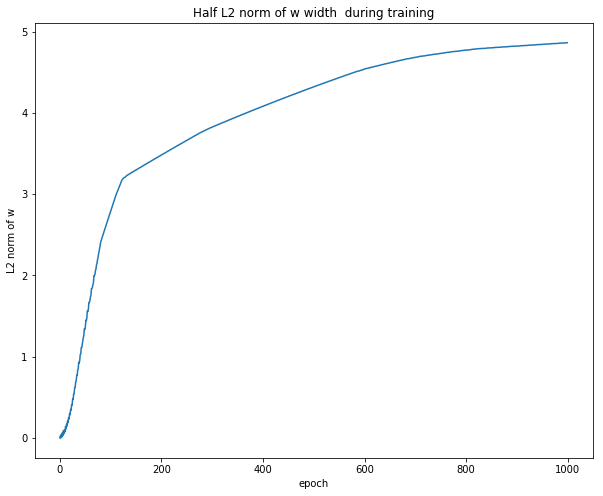

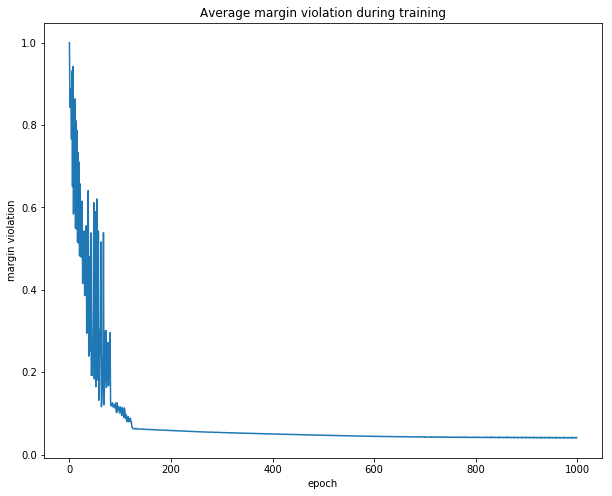

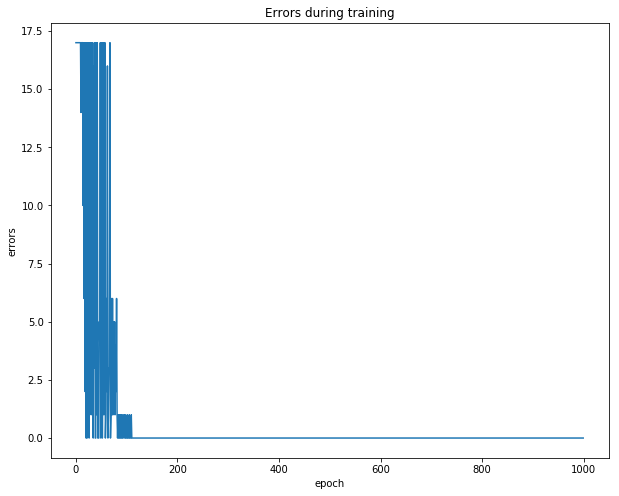

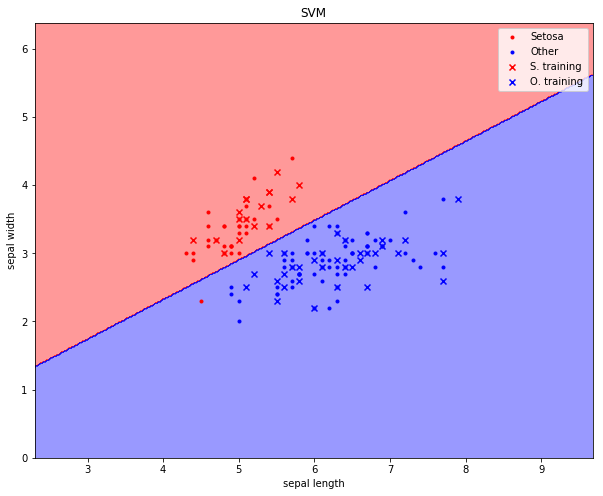

Efficiency (train) = 1.0
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9933333333333333


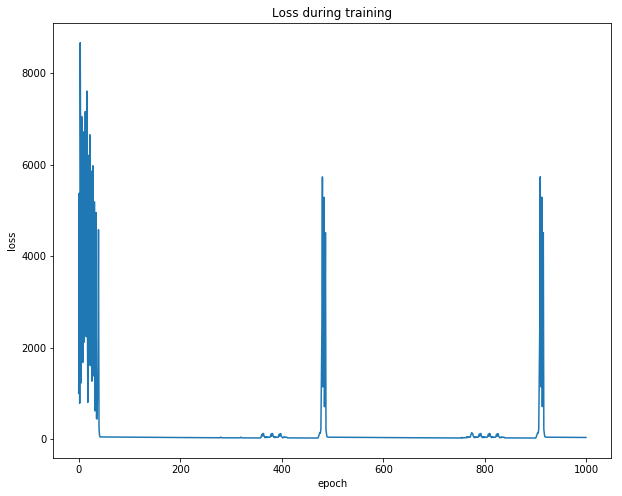

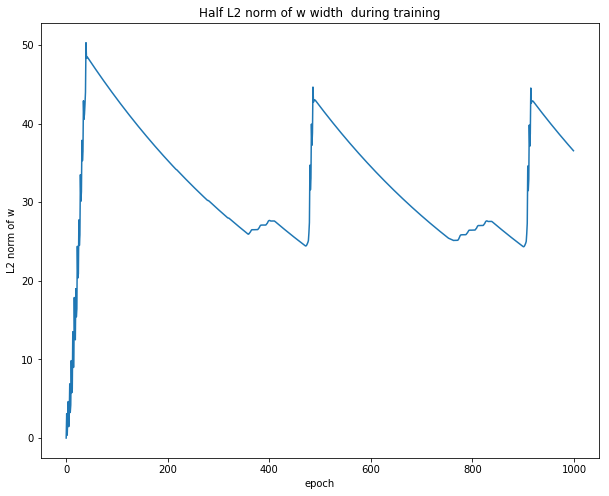

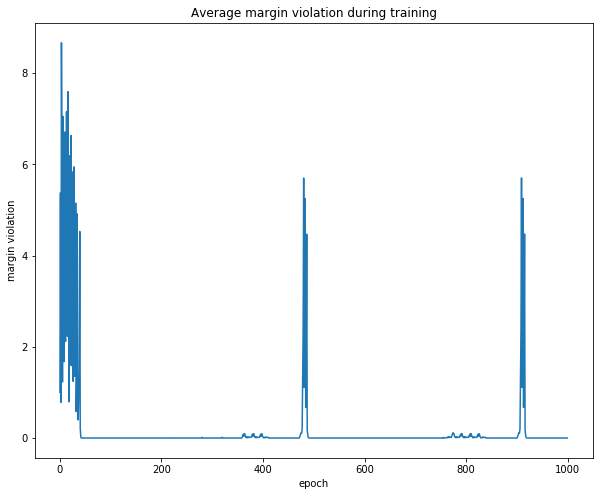

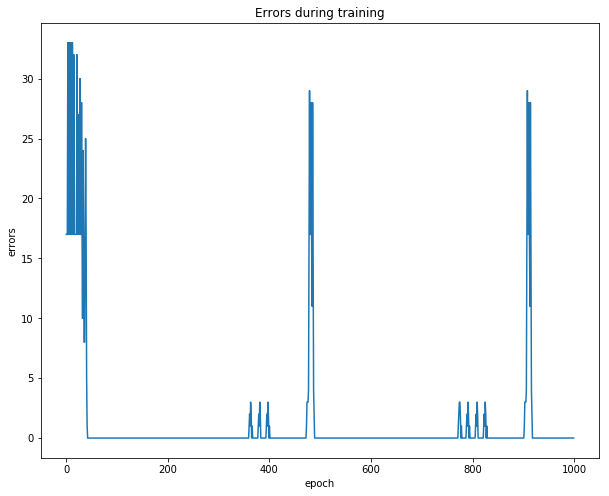

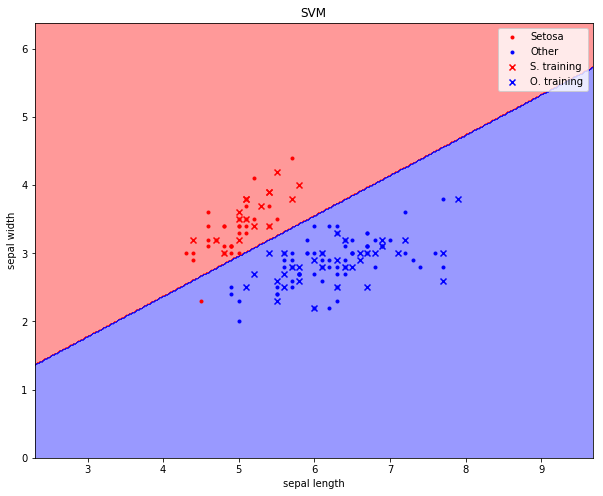

Efficiency (train) = 1.0
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9933333333333333


In [12]:
np.random.seed(1)

X_all, Y_all = prep_iris_data(df)
train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
svm.w_ = np.zeros_like(svm.w_)
svm.learn(X_train, Y_train, mu=1, eta=0.01, epochs=10000) 
svm.plot_train_loss()
svm.plot_train_wnorm()
svm.plot_train_violation()
svm.plot_train_errors() 
svm.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = svm.efficiency(X_train, Y_train)
eff_test = svm.efficiency(X, Y)
eff_all = svm.efficiency(X_all, Y_all)

plt.show()

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

# training
svm.w_ = np.zeros_like(svm.w_)
svm.learn(X_train, Y_train, mu=100, eta=0.001, epochs=1000) 
svm.plot_train_loss()
svm.plot_train_wnorm()
svm.plot_train_violation()
svm.plot_train_errors() 
svm.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = svm.efficiency(X_train, Y_train)
eff_test = svm.efficiency(X, Y)
eff_all = svm.efficiency(X_all, Y_all)

plt.show()

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

# training
svm.w_ = np.zeros_like(svm.w_)
svm.learn(X_train, Y_train, mu=1000, eta=0.001, epochs=1000) 
svm.plot_train_loss()
svm.plot_train_wnorm()
svm.plot_train_violation()
svm.plot_train_errors() 
svm.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = svm.efficiency(X_train, Y_train)
eff_test = svm.efficiency(X, Y)
eff_all = svm.efficiency(X_all, Y_all)

plt.show()

print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)

## Dependence on bad points
The Adaline behaves better compared to the Perceptron when there are training data points that violate the linear separability strongly.

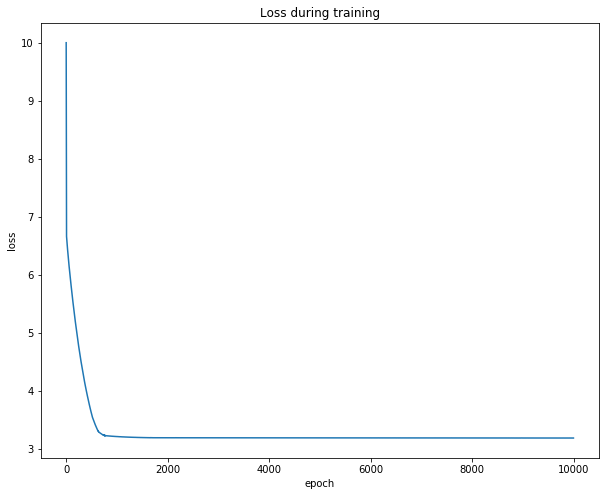

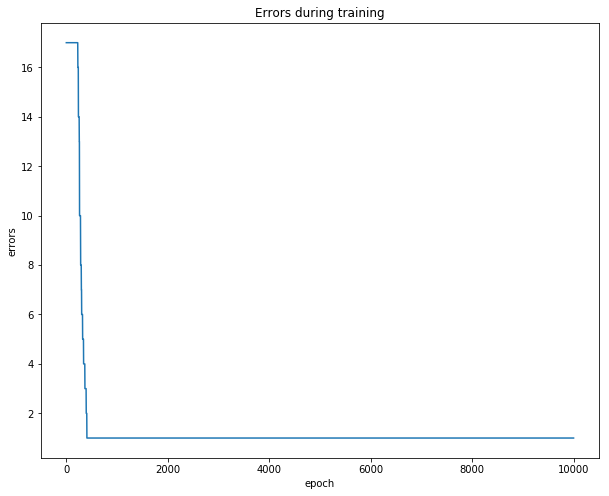

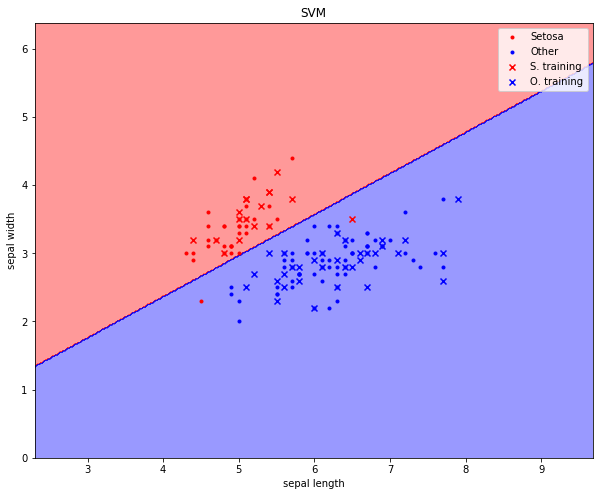

weights: [-0.0718      0.90372161 -1.49999603]
Efficiency (train) = 0.98
Efficiency (test)  = 0.99
Efficiency (all)   = 0.9866666666666667


In [13]:
# fix the generated random numbers (2 seems to select a bad case)
np.random.seed(4)
# here we overwrite an existing point with a 'bad' one
X_all[0] = [6.5, 3.5]
Y_all[0] = -1

train_samples = int( len(X_all) / 3 )
# training data
X_train, Y_train = X_all[:train_samples], Y_all[:train_samples]
# data for testing the efficiency
X, Y = X_all[train_samples:], Y_all[train_samples:]

# training
svm = SVM(X.shape[1])
svm.learn(X_train, Y_train, mu=10, eta=0.001, epochs=10000)
svm.plot_train_loss()
svm.plot_train_errors()

svm.plot_decision_regions(X, Y, X_train, Y_train, 0.02)

eff_train = svm.efficiency(X_train, Y_train)
eff_test = svm.efficiency(X, Y)
eff_all = svm.efficiency(X_all, Y_all)

plt.show()

print('weights:', svm.w_)
print('Efficiency (train) =', eff_train)
print('Efficiency (test)  =', eff_test)
print('Efficiency (all)   =', eff_all)